In [1]:
import mne
import os
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.preprocessing import read_ica
from preprocessing import Preprocessing
from mne import compute_raw_covariance
from datahandling import BcomMEG
from wavelets import *
import matplotlib.pyplot as plt

In [ ]:
empty_room = mne.io.read_raw_fif(
    "/Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_01/2/empty_room_cleaned_ICA_raw.fif",
    preload=True
    )
empty_room.info['bads']
bad_loc_channel = "MEG 173"
empty_room.interpolate_bads(exclude=[bad_loc_channel], origin=(0., 0., 0.))

Opening raw data file /Volumes/BCOM/ciprian_project/data_analyzed/preprocessed/BCOM_01/2/empty_room_cleaned_ICA_raw.fif...
Isotrak not found
    Range : 0 ... 89999 =      0.000 ...   179.998 secs
Ready.
Reading 0 ... 89999  =      0.000 ...   179.998 secs...
Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Computing dot products for 244 MEG channels...
    Computing cross products for 244 → 3 MEG channels...
    Preparing the mapping matrix...
    Truncating at 88/244 components to omit less than 0.0001 (9.6e-05)


<Raw | empty_room_cleaned_ICA_raw.fif, 280 x 90000 (180.0 s), ~192.5 MB, data loaded>

In [3]:
noise_cov = compute_raw_covariance(empty_room, 
                                   method='auto',
                                   rank=None, 
                                   picks="meg")

Using up to 900 segments
Using data from preloaded Raw for 900 events and 100 original time points ...
0 bad epochs dropped
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 247 -> 244
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 90000
log-likelihood on unseen data (descending order):
   shrunk: -1366.306
   diagonal_fixed: -1384.316
   empirical: -1440.840
selecting best estimator: shrunk
[done]


In [4]:
print(noise_cov)
import numpy as np
print("Max:", np.max(noise_cov.data))
print("Min:", np.min(noise_cov.data))
print("Mean:", np.mean(noise_cov.data))
print("Non-zero entries:", np.count_nonzero(noise_cov.data))
print("Total number of entries", noise_cov.data.shape[0]*noise_cov.data.shape[1])

<Covariance | kind : full, shape : (247, 247), range : [-2.9e-26, +6.5e-26], n_samples : 89999>
Max: 6.526209886763194e-26
Min: -2.874467904175791e-26
Mean: 2.7548969836782203e-27
Non-zero entries: 61009
Total number of entries 61009


Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 247 dim * 1.8  max singular value)
    Estimated rank (mag): 244
    MAG: rank 244 computed from 247 data channels with 0 projectors


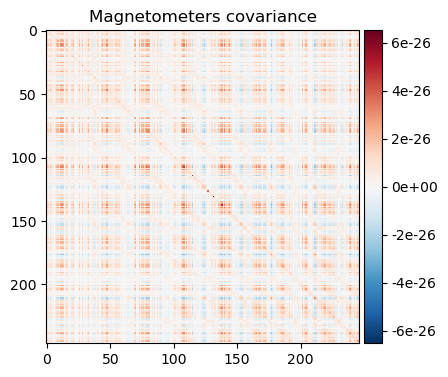

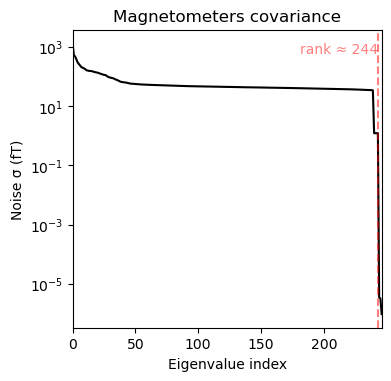

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [5]:
mne.viz.plot_cov(noise_cov, empty_room.info)

## Reconstruction

In [6]:
scaled = "scaled_fsaverage"
subject = "BCOM_01_2"

In [7]:
morphed_bem = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-5120-5120-5120-bem-sol.fif"
morphed_source = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-ico-5-src.fif"
morphed_trans = f"/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/{subject}-trans.fif"


fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

0 files missing from root.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage


In [139]:
dir = '/Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT'
subjects = [subject]
picks = None

data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=True, avoid_producing=False)

Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_si_156-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_ma_132-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction a

In [144]:
data.data[subject]['sa_152']

<EpochsFIF | 13 events (all good), -0.4 – 0.8 s (baseline off), ~15.3 MB, data loaded,
 '152': 13>

In [145]:
evoked_reading = data.data[subject]['sa_152']
print(evoked_reading)

for syllable, epochs in data.data[subject].items():
    if syllable != "sa_52":
        evoked_reading = mne.concatenate_epochs((evoked_reading, epochs))

# evoked_reading = evoked_reading.copy().apply_baseline((-0.2,0)).average()
evoked_reading=evoked_reading.copy().average()

<EpochsFIF | 13 events (all good), -0.4 – 0.8 s (baseline off), ~15.3 MB, data loaded,
 '152': 13>
Not setting metadata
19 matching events found


No baseline correction applied
Not setting metadata
37 matching events found
No baseline correction applied
Not setting metadata
45 matching events found
No baseline correction applied
Not setting metadata
58 matching events found
No baseline correction applied
Not setting metadata
75 matching events found
No baseline correction applied
Not setting metadata
88 matching events found
No baseline correction applied
Not setting metadata
95 matching events found
No baseline correction applied
Not setting metadata
109 matching events found
No baseline correction applied
Not setting metadata
115 matching events found
No baseline correction applied
Not setting metadata
131 matching events found
No baseline correction applied
Not setting metadata
136 matching events found
No baseline correction applied
Not setting metadata
148 matching events found
No baseline correction applied
Not setting metadata
161 matching events found
No baseline correction applied
Not setting metadata
172 matching event

No projector specified for this dataset. Please consider the method self.add_proj.


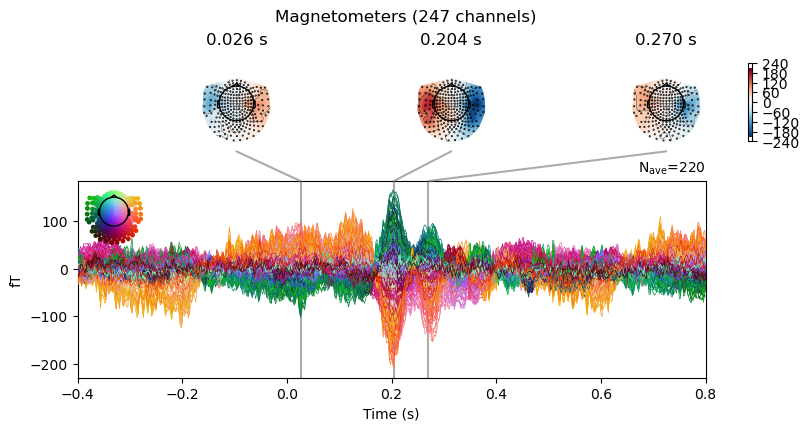

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 247 dim * 1.8  max singular value)
    Estimated rank (mag): 244
    MAG: rank 244 computed from 247 data channels with 0 projectors
Computing rank from covariance with rank={'mag': 244}
    Setting small MAG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 244 (3 small eigenvalues omitted)


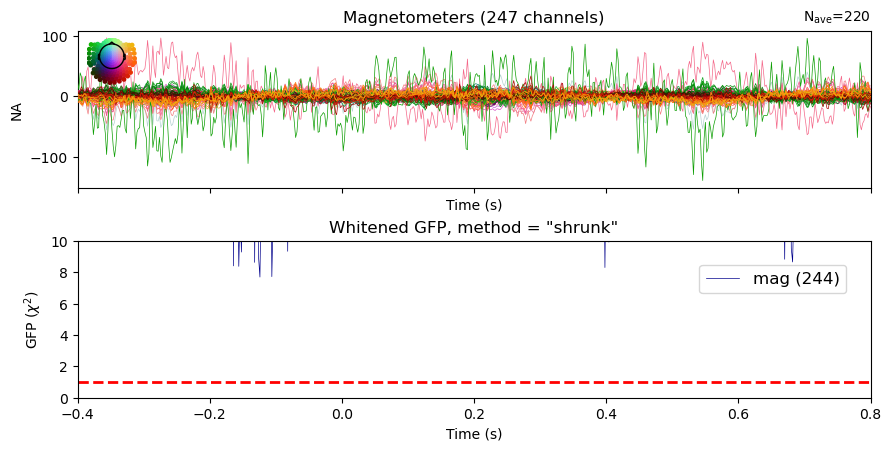

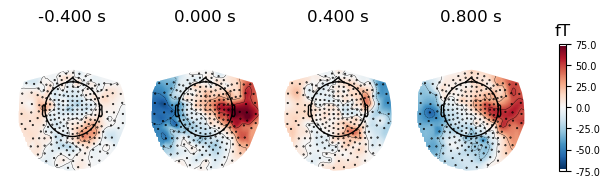

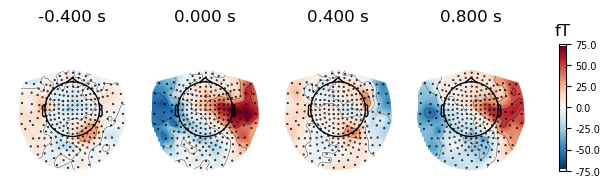

In [146]:
evoked_reading.plot_joint()
evoked_reading.plot_white(noise_cov)
evoked_reading.plot_topomap(ch_type="mag")

In [ ]:
fwd = mne.make_forward_solution(
    evoked_reading.info,
    trans=morphed_trans,
    src=morphed_source, 
    bem=morphed_bem, 
    meg=True, 
    eeg=False
)

Source space          : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-ico-5-src.fif
MRI -> head transform : /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/BCOM_01_2-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_01_2/bem/scaled_fsaverage_BCOM_01_2-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999667 -0.010944 -0.023385       1.50 mm
    0.010999 0.999937 0.002219      25.63 mm
    0.023359 -0.002476 0.999724      34.46 mm
    0.000000 0.000000 0.000000       1.00

Read 247 MEG channels from info
105 coil 

In [147]:
#create inverse operator
inverse_operator = mne.minimum_norm.make_inverse_operator(
    evoked_reading.info, 
    fwd, 
    noise_cov, 
    loose=0.2, #surface so this is equivalent to auto - weights the source variances of the dipole components parallel to cortical surface, 
    depth=0.8, #actually this is ignored for eLoreta; but determines the weight of the forward using depth prior
)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 247 channels.
    247 out of 247 channels remain after picking
Selected 247 channels
Creating the depth weighting matrix...
    247 magnetometer or axial gradiometer channels
    limit = 20322/20484 = 10.048732
    scale = 3.58627e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 247 dim * 1.8  max singular value)
    Estimated rank (mag): 244
    MAG: rank 244 computed from 247 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitene

In [148]:
# applt inverse operator for all of the epochs
snr = 3.0 # idea that the signal is pretty noisy
lambda2 = 1.0/snr**2 # regularization parameter

stc = mne.minimum_norm.apply_inverse(
    evoked_reading,
    inverse_operator=inverse_operator,
    lambda2=lambda2,
    method='dSPM'
)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 220
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 244 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.12 × 152 + 0.03 × 156 + 0.08 × 132 + 0.04 × 144 + 0.06 × 146 + 0.08 × 112 + 0.06 × 162 + 0.03 × 124 + 0.06 × 142 + 0.03 × 166 + 0.07 × 122 + 0.02 × 154 + 0.05 × 134 + 0.05 × 136 + 0.06 × 126 + 0.05 × 114 + 0.05 × 116 + 0.05 × 164"...
    Picked 247 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  93.2% variance
    Combining the current components...
    dSPM...
[done]


In [149]:
brain = stc.plot(hemi='both')
brain.add_label(label=label, borders=True, color='red')

Using control points [19.85692611 22.04341613 39.99819611]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x10a393720> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x382d05e10> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3e8b58270> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3e8b59420> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3e8b50fe0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3e8b522a0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3e8b52c30> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

## Morph back to FSAverage for labels to match

In [150]:
morph = mne.compute_source_morph(
    src=inverse_operator['src'],
    subject_from=f"{scaled}_{subject}",#morphedfsaveragefoldername, i.e., fsaverage_scaled xxx 
    subject_to='fsaverage',
    # subjects_dir=,#saving directory?
)

morphed_stc = morph.apply(stc)

surface source space present ...
Computing morph matrix...


    Left-hemisphere map read.
    Right-hemisphere map read.
    2 smooth iterations done.
    2 smooth iterations done.
[done]
[done]


In [151]:
morphed_stc.plot(hemi='split')

Using control points [19.85692611 22.04341613 39.99819611]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x334a5c9d0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x31fe71b90> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x10a2b8c00> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x10a2ba0f0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x10a2bec10> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x10a240c30> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x10a26d4c0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

In [152]:
# read labels from fsaverage annotation using aparc parcellation
labels = mne.read_labels_from_annot(
    subject='fsaverage', 
    parc='aparc.a2009s', 
    hemi='lh',
    subjects_dir=subjects_dir)
labels


Reading labels from parcellation...
   read 75 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.a2009s.annot


[<Label | fsaverage, 'G_Ins_lg_and_S_cent_ins-lh', lh : 769 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Ant-lh', lh : 2171 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Mid-Ant-lh', lh : 1957 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Mid-Post-lh', lh : 2386 vertices>,
 <Label | fsaverage, 'G_and_S_frontomargin-lh', lh : 932 vertices>,
 <Label | fsaverage, 'G_and_S_occipital_inf-lh', lh : 1277 vertices>,
 <Label | fsaverage, 'G_and_S_paracentral-lh', lh : 2272 vertices>,
 <Label | fsaverage, 'G_and_S_subcentral-lh', lh : 2607 vertices>,
 <Label | fsaverage, 'G_and_S_transv_frontopol-lh', lh : 627 vertices>,
 <Label | fsaverage, 'G_cingul-Post-dorsal-lh', lh : 1098 vertices>,
 <Label | fsaverage, 'G_cingul-Post-ventral-lh', lh : 520 vertices>,
 <Label | fsaverage, 'G_cuneus-lh', lh : 1430 vertices>,
 <Label | fsaverage, 'G_front_inf-Opercular-lh', lh : 1800 vertices>,
 <Label | fsaverage, 'G_front_inf-Orbital-lh', lh : 453 vertices>,
 <Label | fsaverage, 'G_front_inf-Triangul

In [153]:
label = [label for label in labels if 'G_occipital_middle-lh' in label.name][0]
label

<Label | fsaverage, 'G_occipital_middle-lh', lh : 2098 vertices>

In [154]:
src = mne.read_source_spaces("/Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif")
label_time_courses = mne.extract_label_time_course(
    morphed_stc,
    label,
    src=src,
    mode='mean_flip',
    return_generator=False,
)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Extracting time courses for 1 labels (mode: mean_flip)


In [155]:
import pywt
sampling_rate = 300 # data already downsampled to 300 at this point
log_samples = 100 # we want 100 coefficients
cwt_wavelet_name = 'cmor' # reconstruction wavelet
B = 1.0 # wavelet bandwith (higher means more frequencies at each scale, but less precision in peak timing)
C = 1.0 # central frequency (higher means more oscialltions per time window, meaning higher frequency features per scale)
cwt_wavelet = f'{cwt_wavelet_name}{B}-{C}'
frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
sampling_period = 1/sampling_rate
scales = pywt.central_frequency(wavelet=cwt_wavelet)/ (frequencies * sampling_period)
dwt_wavelet_name='db4' # denoizing wavelet 
level=5 # level of decomposition. NB in Dash et al. they use 7, but our signal is shorter, so 5 is max
x = process_channel(
                    signal=label_time_courses,
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

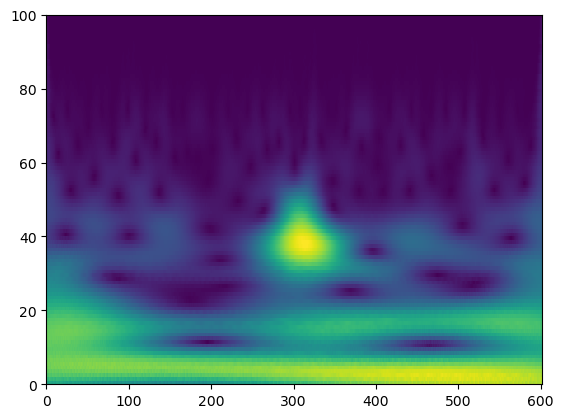

In [156]:
# Reshape x to a 2D array with shape (-1, x.shape[-1]) (flatten all but the last dimension)
x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
x = x.squeeze()
plt.pcolormesh(x)

In [54]:
baseline = mne.io.read_raw_fif("/Volumes/BCOM/ciprian_project/data_analyzed/baselines/BCOM_01/BCOM_01_2_baseline_raw.fif")

Opening raw data file /Volumes/BCOM/ciprian_project/data_analyzed/baselines/BCOM_01/BCOM_01_2_baseline_raw.fif...
    Range : 18384 ... 32784 =     36.768 ...    65.568 secs
Ready.


In [70]:
baseline.pick([ch for ch in baseline.ch_names if ch in data.data[subject]['sa_52'].ch_names])

<Raw | BCOM_01_2_baseline_raw.fif, 247 x 14401 (28.8 s), ~554 kB, data not loaded>

In [76]:
baseline_data = baseline.get_data()

In [50]:
y = process_channel(
                    signal=data.data[subject]['sa_52'][0]._data.squeeze(0)[0],
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

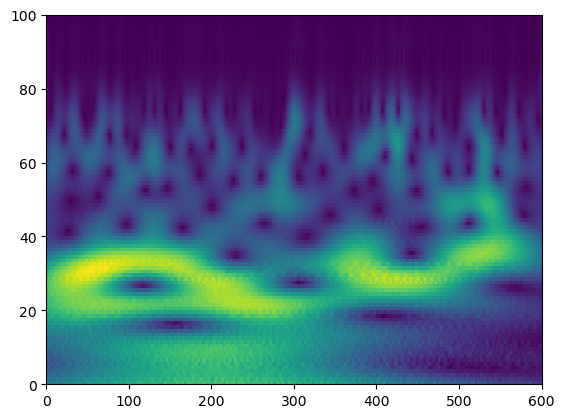

In [52]:
plt.pcolormesh(y)

In [ ]:
b = process_channel(
                    signal=baseline_data[0],
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

In [86]:
row_wise_mean = b.mean(axis=1)
row_wise_mean.shape

(100,)

In [107]:
y_adjust = np.zeros_like(y)

for i, row in enumerate(y):
    y_adjust[i] =  row -row_wise_mean[i]

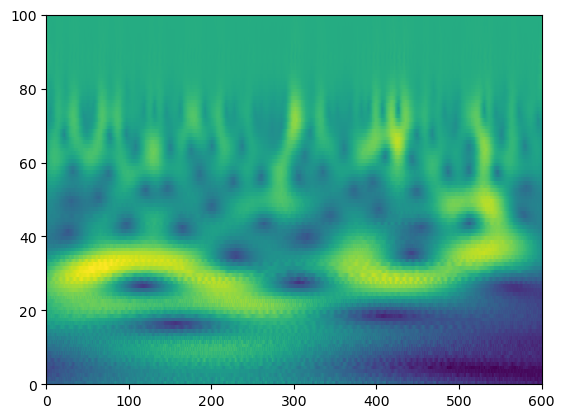

In [108]:
plt.pcolormesh(y_adjust)

In [109]:
dir = '/Volumes/BCOM/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
subjects = [subject]
picks = None

data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=False, avoid_producing=True)

Reading /Volumes/BCOM/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_01_2_le_24-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_01_2_ma_32-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_01_2_te_64-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/B

In [136]:
z = process_channel(
                    signal=data.data[subject]['sa_52'][1]._data.squeeze(0)[0],
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

In [137]:
data.data[subject]['sa_52'][0]._data.squeeze(0)[0].shape

(241,)

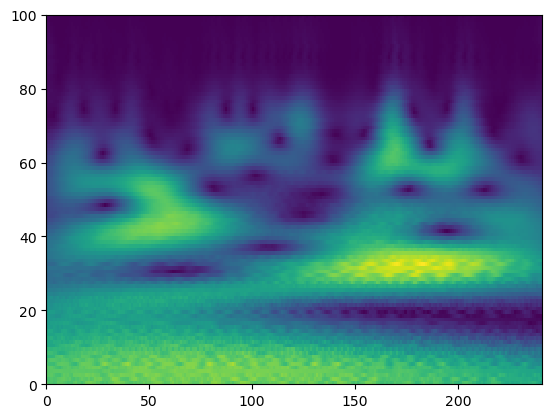

In [138]:
plt.pcolormesh(z)

In [113]:
y.shape

(100, 601)

In [114]:
z.shape

(100, 241)

In [129]:
dir = '/Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT'
subjects = [subject]
picks = None

data_long = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=False, avoid_producing=True)

Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_le_24-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_ma_32-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/BCOM/ciprian_project/data_analyzed/non_normalized/data/WITHOUT_BADS/COVERT/BCOM_01_2_te_64-epo.fif ...
    Found the data of interest:
        t =    -400.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction app

In [130]:
for epo in data_long.data[subject]:
    data_long.data[subject][epo] = data_long.data[subject][epo].resample(300).crop(tmin=-0.3, tmax=0.5)
    

In [131]:
data_long.data[subject]['sa_52'][0]._data.squeeze(0)[0].shape

(241,)

In [134]:
asdf = process_channel(
                    signal=data_long.data[subject]['sa_52'][1]._data.squeeze(0)[0],
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                )

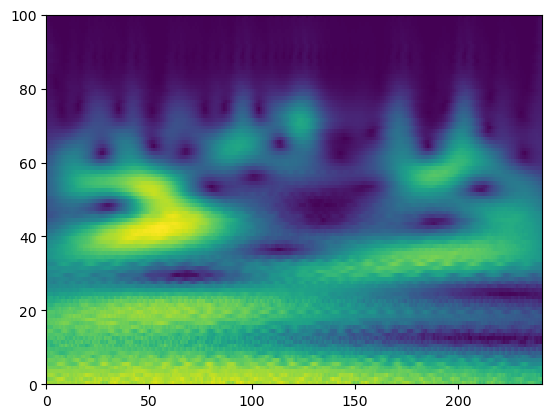

In [135]:
plt.pcolormesh(asdf)